# 02 Using tf.data.datasets and TensorFlow feature columns on structured data

This Notebook demonstrates how to create TensorFlow input pipelines. We will use Keras to define the model, and tf.feature_column as a bridge to map from columns in a CSV to features used to train the model.

# 1 - Setup

### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import pathlib

2022-02-18 07:18:03.014231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 07:18:03.014270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2 - Preparing Dataset

### Use Pandas to create a dataframe

We will use a simplified version of the PetFinder dataset. There are several thousand rows in the CSV. Each row describes a pet, and each column describes an attribute. We will use this information to predict the speed at which the pet will be adopted.

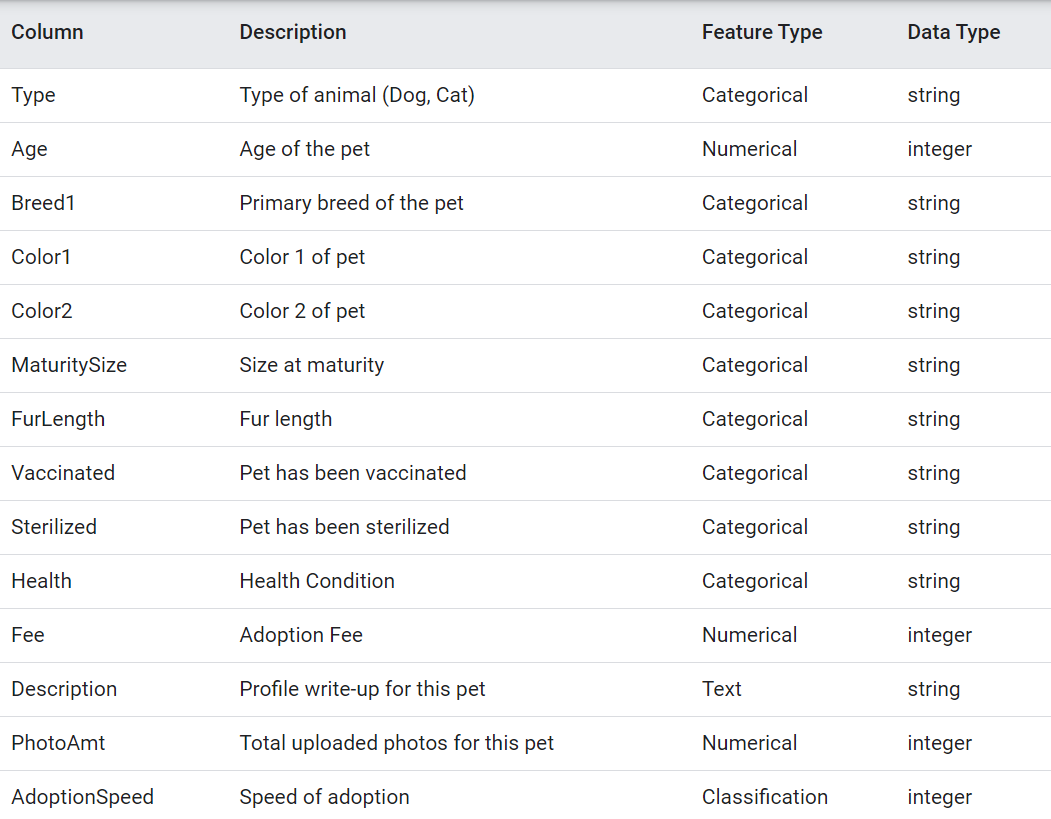

In [2]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [3]:
dataframe.head()

Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  \
0     Short         No         No  Healthy  100   
1    Medium   Not Sure   Not Sure  Healthy    0   
2    Medium        Yes         No  Healthy    0   
3     Short        Yes         No  Healthy  150   
4     Short         No         No  Healthy    0   

                                         Description  PhotoAmt  AdoptionSpeed  
0  Nibble is a 3+ month old ball of cuteness. He ...         1              2  
1  I just found it alone yesterday near my apartm...         2              0  
2  Their pregnant mother was dumped by her irresp...         7              3  
3  Good guard dog, very alert, active, obedience ...         8              2  
4  This handsome yet cute boy is up for adoption....         3              2

## Create target variable

The task in the original dataset is to predict the speed at which a pet will be adopted. Let's simplify this for our Notebook. Here, we will transform this into a binary classification problem, and simply predict whether the pet was adopted, or not.

After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

In [4]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## Split the dataframe into train, validation, and test

The dataset we downloaded was a single CSV file. We will split this into train, validation, and test sets.
- Training data — used for training the model
- Validation data — used for tuning the hyperparameters and evaluate the models
- Test data — used to test the model after the model has gone through initial vetting by the validation set.

In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


# 3 - Create an input pipeline using tf.data

Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model.

The tf.data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths.

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components

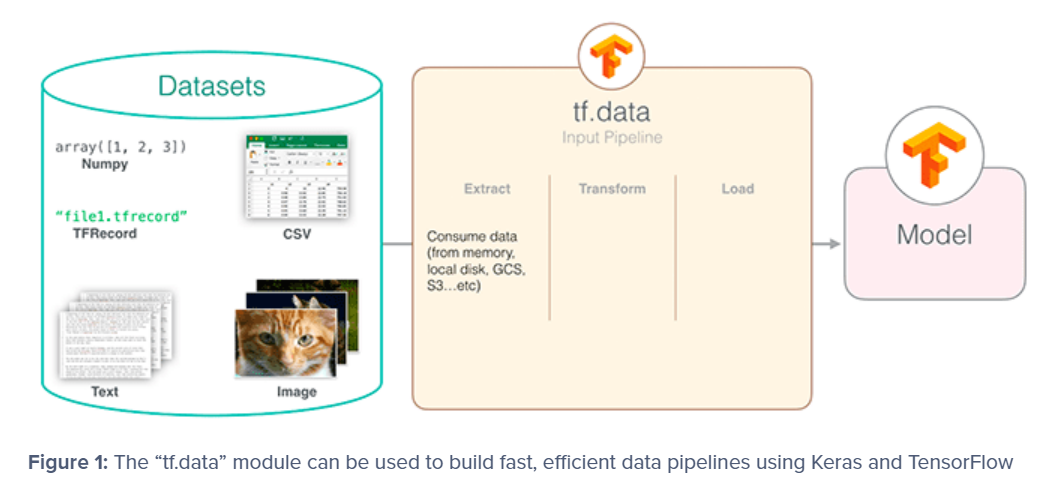

Image source: https://www.kaggle.com/jalammar/intro-to-data-input-pipelines-with-tf-data

GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build flexible and efficient input pipelines. 

In [6]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [7]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

2022-02-18 07:18:12.254027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-18 07:18:12.254072: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-18 07:18:12.254098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zulily-tfx-pipeline-testing-new-notebook): /proc/driver/nvidia/version does not exist
2022-02-18 07:18:12.277446: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [8]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([36  5  8  1  1], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 0 1 0], shape=(5,), dtype=int64)


##### We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

# 4 - Demonstrate several types of feature columns

TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [9]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [10]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

## Numeric columns

The output of a feature column becomes the input to the model. A numeric column is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [11]:
photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[2.]
 [1.]
 [3.]
 [5.]
 [3.]]


## Bucketized columns

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a bucketized column. Notice the one-hot values below describe which age range each row matches.

In [12]:
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


## Categorical columns

In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector.

In [13]:
animal_type = feature_column.categorical_column_with_vocabulary_list(
      'Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


## Embedding columns

Suppose instead of having just a few possible strings, we have thousands values per category.As the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an embedding column represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

In [14]:
# Notice the input to the embedding column is the categorical column
# we previously created
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[-0.07573039 -0.18402511  0.3146223  -0.15436332 -0.366429    0.2853689
  -0.0791211   0.20426737]
 [ 0.11642174  0.18015097  0.0987513   0.18303299  0.13649632 -0.2205337
   0.5591593   0.11478915]
 [ 0.49465737 -0.20317566 -0.36407796  0.03193754  0.35588107  0.4734795
  -0.09545428  0.09698644]
 [ 0.4529114  -0.09711554  0.42958406  0.17121558 -0.19942814 -0.55270183
   0.09693336 -0.28698438]
 [ 0.11642174  0.18015097  0.0987513   0.18303299  0.13649632 -0.2205337
   0.5591593   0.11478915]]


## Hashed feature columns

Another way to represent a categorical column with a large number of values is to use a categorical_column_with_hash_bucket. This feature column calculates a hash value of the input, then selects one of the hash_bucket_size buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket.

In [15]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Crossed feature columns

Combining features into a single feature, better known as feature crosses, enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of Age and Type. Note that crossed_column does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a hashed_column, so you can choose how large the table is.

In [16]:
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Choose which columns to use

We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this Notebook is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

In [17]:
feature_columns = []

# numeric cols
for header in ['PhotoAmt', 'Fee', 'Age']:
  feature_columns.append(feature_column.numeric_column(header))

In [18]:
# bucketized cols
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [19]:
# indicator_columns
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [20]:
# embedding columns
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [21]:
# crossed columns
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

## Create a feature layer

Now that we have defined our feature columns, we will use a DenseFeatures layer to input them to our Keras model.

In [22]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [23]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# 5 - Create, compile, and train the model

### Model building 

### Create the model architecture
- In this notebook we are using the Sequential model API to create a simple CNN model, consisting of a feature layer followed by a dense layer and then a Dropout. 

- `Note`: you only need to define the input data shape with the first layer.

Building the neural network requires configuring the layers of the model, then compiling the model.

1) Set up the layers- The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. 

    - `activation`: Activation function decides, whether a neuron should be activated or not.
        - `relu function`:The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero
            - With default values, this returns the standard ReLU activation: max(x, 0), the element-wise maximum of 0 and the input tensor.
            - The rectified linear activation function overcomes the `vanishing gradient` problem, allowing models to learn faster and perform better.
        - `Softmax` The softmax function is used as the activation function in the `output layer` of neural network models that predict a `multinomial` probability distribution. That is, softmax is used as the activation function for `multi-class classification` problems where class membership is required on more than two class labels.


2) Creating a Sequential model API 

### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step below:

- `Loss function` —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
    - it is recommended to use `categorical_crossentropy` for multi-class(classes are mutually exclusive) problem but binary_crossentropy for multi-label problem
    - targets should be encoded as one-hot vectors.
- `Optimizer` —This is how the model is updated based on the data it sees and its loss function.
    - Optimizers are Classes or methods used to change the attributes of your machine/deep learning model such as weights and learning rate in order to reduce the losses
    - `Adam` is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
- `Metrics` —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.
    - A metric is a function that is used to judge the performance of your model. Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model

### Train the model
Training the neural network model requires the following steps:

1) Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
2) The model learns to associate images and labels.
3) You ask the model to make predictions about a test set—in this example, the test_images array.
4) Verify that the predictions match the labels from the test_labels array.

### Fit the model
To start training, call the `model.fit()` method—so called because it "fits" the model to the training data:

The `batch size` is a number of samples processed before the model is updated. The number of `epochs` is the number of complete passes through the training dataset. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

In [24]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
219/231 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.6881WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=string>, 'Age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Breed1': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>, 'Gender': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=string>, 'Color1': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'Color2': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'MaturitySize': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=string>, 'FurLength': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'Vaccinated': <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=string>, 'Sterilized': <tf.Tensor 'It

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_6 (DenseFeat  multiple                 1328      
 ures)                                                           
                                                                 
 dense (Dense)               multiple                  19328     
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 37,297
Trainable params: 37,297
Non-trainable params: 0
____________________________________________________

In [28]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

73/73 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.7088
Accuracy 0.7088388204574585
